# Convolution

https://zh-v2.d2l.ai/chapter_convolutional-neural-networks/lenet.html

## LeNET

In [1]:
import torch
from torch import nn

import torch.optim as optim
import torchvision
import math
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils import data
from torchvision import transforms
import seaborn as sns
sns.set()
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torchvision import transforms

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

In [2]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [3]:
batch_size = 256

trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=False)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=False)

train_set, val_set = torch.utils.data.random_split(mnist_train, [50000, 10000])
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, drop_last=False)

In [4]:
numpy = lambda x, *args, **kwargs: x.detach().numpy(*args, **kwargs)
size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)
reshape = lambda x, *args, **kwargs: x.reshape(*args, **kwargs)
to = lambda x, *args, **kwargs: x.to(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)
transpose = lambda x, *args, **kwargs: x.t(*args, **kwargs)
reduce_mean = lambda x, *args, **kwargs: x.mean(*args, **kwargs)
expand_dims = lambda x, *args, **kwargs: x.unsqueeze(*args, **kwargs)
swapaxes = lambda x, *args, **kwargs: x.swapaxes(*args, **kwargs)
repeat = lambda x, *args, **kwargs: x.repeat(*args, **kwargs)
def accuracy(y_hat, y):
    """Compute the number of correct predictions.
    Defined in :numref:`sec_utils`"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = argmax(y_hat, axis=1)
    cmp = astype(y_hat, y.dtype) == y
    return float(reduce_sum(astype(cmp, y.dtype)))

In [5]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            # metric.add(d2l.accuracy(net(X), y), y.numel())
    return accuracy(net(X), y) / y.numel()

In [6]:
def train_Fashion_mnist(net, train_iter, test_iter, num_epochs, lr, device, model_name):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    num_batches = len(train_iter)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    train_loss,train_acc_,test_acc_ = [],[],[]
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        net.train()
        for i, (X, y) in enumerate(train_iter):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()

            train_l = l * X.shape[0] / X.shape[0]
            train_acc = accuracy(y_hat, y) / X.shape[0]
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        # animator.add(epoch + 1, (None, None, test_acc))
        print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
            f'test acc {test_acc:.3f}')
        train_loss.append(train_l.item())
        train_acc_.append(train_acc)
        test_acc_.append(test_acc)
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    plt.plot(train_loss,label='train_loss')
    plt.plot(train_acc_,label='train_acc_')
    plt.plot(test_acc_,label='test_acc_')
    ax.legend(loc="upper left", fancybox=True)
    ax.set_title(model_name)
        

training on cpu
loss 2.298, train acc 0.113, test acc 0.062
loss 1.036, train acc 0.588, test acc 0.750
loss 0.678, train acc 0.713, test acc 0.875
loss 0.518, train acc 0.787, test acc 0.812
loss 0.696, train acc 0.713, test acc 0.875
loss 0.507, train acc 0.787, test acc 0.812
loss 0.668, train acc 0.725, test acc 0.812
loss 0.651, train acc 0.725, test acc 0.812
loss 0.458, train acc 0.787, test acc 0.938
loss 0.477, train acc 0.775, test acc 0.875


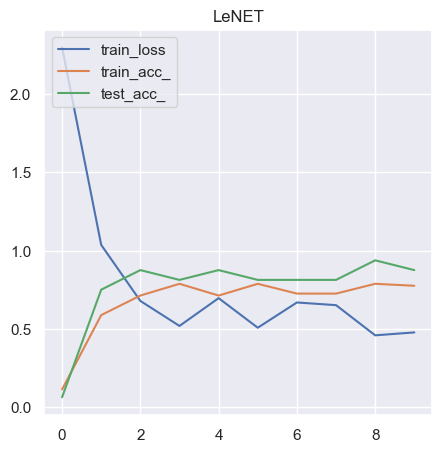

In [7]:
lr, num_epochs = 0.9, 10
train_Fashion_mnist(net,train_loader,test_loader,num_epochs,lr,"cpu",'LeNET')

### LeNet with Batchnorm

In [74]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # 缩放和移位
    return Y, moving_mean.data, moving_var.data

class BatchNorm(nn.Module):
    # num_features：完全连接层的输出数量或卷积层的输出通道数。
    # num_dims：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var
        # 复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

In [75]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

training on cuda:7
loss 0.493, train acc 0.800, test acc 0.875
loss 0.451, train acc 0.825, test acc 0.812
loss 0.359, train acc 0.863, test acc 1.000
loss 0.414, train acc 0.838, test acc 0.750
loss 0.378, train acc 0.887, test acc 0.875
loss 0.516, train acc 0.838, test acc 0.875
loss 0.325, train acc 0.900, test acc 1.000
loss 0.237, train acc 0.900, test acc 0.938
loss 0.275, train acc 0.925, test acc 0.938
loss 0.213, train acc 0.912, test acc 0.938


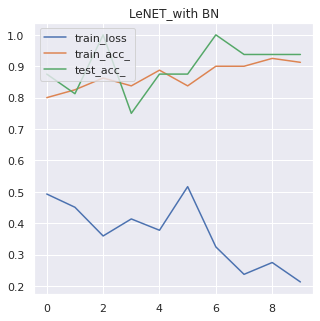

In [77]:
lr, num_epochs, batch_size = 0.5, 10, 256

train_Fashion_mnist(net,train_loader,test_loader,num_epochs,lr,"cuda:7",'LeNET_with BN')

## AlexNET

In [63]:
import torch
from torch import nn
# from d2l import torch as d2l

net = nn.Sequential(
    # 这里，我们使用一个11*11的更大窗口来捕捉对象。
    # 同时，步幅为4，以减少输出的高度和宽度。
    # 另外，输出通道的数目远大于LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口。
    # 除了最后的卷积层，输出通道的数量进一步增加。
    # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
    nn.Linear(4096, 10))

In [6]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory.
    Defined in :numref:`sec_utils`"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=4),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=4))

In [65]:
batch_size = 128
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=224)

training on cuda:7
loss 0.589, train acc 0.771, test acc 0.875
loss 0.505, train acc 0.802, test acc 0.938
loss 0.395, train acc 0.875, test acc 0.938
loss 0.426, train acc 0.833, test acc 0.938
loss 0.446, train acc 0.833, test acc 1.000
loss 0.424, train acc 0.865, test acc 1.000
loss 0.357, train acc 0.885, test acc 1.000
loss 0.240, train acc 0.906, test acc 0.938
loss 0.266, train acc 0.927, test acc 1.000
loss 0.297, train acc 0.875, test acc 1.000


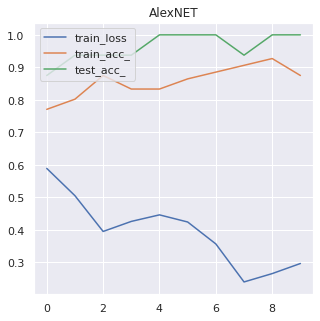

In [66]:
lr, num_epochs = 0.01, 10
# d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
train_Fashion_mnist(net,train_iter,test_iter,num_epochs,lr,"cuda:7",'AlexNET')

## VGG

In [22]:
import torch
from torch import nn


def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

In [23]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

net = vgg(conv_arch)

In [24]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)#small vgg

training on cuda:7
loss 0.499, train acc 0.771, test acc 0.938
loss 0.361, train acc 0.885, test acc 0.875
loss 0.356, train acc 0.875, test acc 1.000
loss 0.230, train acc 0.896, test acc 1.000
loss 0.231, train acc 0.906, test acc 1.000
loss 0.329, train acc 0.875, test acc 1.000
loss 0.226, train acc 0.927, test acc 1.000
loss 0.122, train acc 0.948, test acc 1.000
loss 0.117, train acc 0.958, test acc 1.000
loss 0.203, train acc 0.917, test acc 0.938


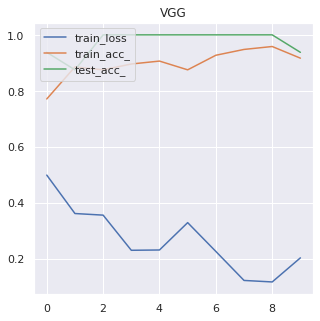

In [25]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=224)
train_Fashion_mnist(net,train_iter,test_iter,num_epochs,lr,"cuda:7",'VGG')

## ResNET

In [27]:
import torch
from torch import nn
from torch.nn import functional as F


class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [28]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

training on cuda:7
loss 0.394, train acc 0.844, test acc 0.938
loss 0.242, train acc 0.906, test acc 0.875
loss 0.258, train acc 0.906, test acc 0.938
loss 0.172, train acc 0.948, test acc 0.938
loss 0.204, train acc 0.927, test acc 0.875
loss 0.126, train acc 0.958, test acc 0.875
loss 0.171, train acc 0.948, test acc 0.875
loss 0.148, train acc 0.979, test acc 0.875
loss 0.032, train acc 0.990, test acc 0.875
loss 0.020, train acc 1.000, test acc 1.000


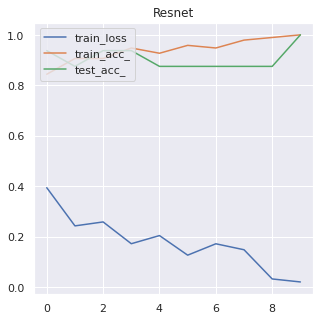

In [29]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=224)
train_Fashion_mnist(net,train_iter,test_iter,num_epochs,lr,"cuda:7",'Resnet')